

Connecting google colab to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


importing the three classes to google colab

In [2]:
import os
image_folder = "/content/drive/MyDrive/coffeedataset2"
print(os.listdir(image_folder))


['HEALTH~1', 'leaf rust', 'phoma']


Loading the dataset

In [3]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow

# =============================
# Paths
# =============================
input_dir = "/content/drive/MyDrive/coffeedataset2"
output_dir = "/content/drive/MyDrive/segmented_results"
os.makedirs(output_dir, exist_ok=True)

# Correct class folder names
classes = ["leaf rust", "phoma"]

# =============================
# Segmentation function
# =============================
def segment_leaf(image_path, save_prefix):
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Error loading {image_path}")
        return

    # Gaussian blur to reduce noise
    img_blur = cv2.GaussianBlur(img, (5, 5), 0)

    # Convert to HSV
    hsv = cv2.cvtColor(img_blur, cv2.COLOR_BGR2HSV)

    # --------------------
    # Leaf Rust (yellow/orange lesions)
    # --------------------
    lower_rust = np.array([15, 100, 100])
    upper_rust = np.array([35, 255, 255])
    mask_rust = cv2.inRange(hsv, lower_rust, upper_rust)

    # --------------------
    # Phoma (black spots)
    # --------------------
    lower_phoma = np.array([0, 0, 0])
    upper_phoma = np.array([179, 115, 115])  # dark black/gray
    mask_phoma = cv2.inRange(hsv, lower_phoma, upper_phoma)

    # Remove overlap with rust
    mask_phoma = cv2.bitwise_and(mask_phoma, cv2.bitwise_not(mask_rust))

    # Morphological cleaning
    kernel = np.ones((3, 3), np.uint8)
    mask_rust = cv2.morphologyEx(mask_rust, cv2.MORPH_OPEN, kernel)
    mask_rust = cv2.morphologyEx(mask_rust, cv2.MORPH_CLOSE, kernel)
    mask_phoma = cv2.morphologyEx(mask_phoma, cv2.MORPH_OPEN, kernel)
    mask_phoma = cv2.morphologyEx(mask_phoma, cv2.MORPH_CLOSE, kernel)

    # --------------------
    # Draw contours
    # --------------------
    output = img.copy()

    contours_rust, _ = cv2.findContours(mask_rust, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours_rust:
        if cv2.contourArea(cnt) > 50:
            cv2.drawContours(output, [cnt], -1, (0,0,255), 2)
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.putText(output, "leaf rust", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)

    contours_phoma, _ = cv2.findContours(mask_phoma, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours_phoma:
        if cv2.contourArea(cnt) > 50:
            cv2.drawContours(output, [cnt], -1, (255,0,0), 2)
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.putText(output, "Phoma", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)

    # --------------------
    # Overlay
    # --------------------
    overlay = img.copy()
    overlay[np.where(mask_rust != 0)] = [0,0,255]
    overlay[np.where(mask_phoma != 0)] = [255,0,0]
    overlay_combined = cv2.addWeighted(img, 0.7, overlay, 0.3, 0)

    # --------------------
    # Save results
    # --------------------
    save_base = os.path.join(output_dir, save_prefix)
    cv2.imwrite(save_base + "_mask_rust.jpg", mask_rust)
    cv2.imwrite(save_base + "_mask_phoma.jpg", mask_phoma)
    cv2.imwrite(save_base + "_overlay.jpg", overlay_combined)
    cv2.imwrite(save_base + "_boundaries.jpg", output)

    print(f"✅ Processed and saved results for {image_path}")


# =============================
# Run on all dataset images
# =============================
for cls in classes:
    class_dir = os.path.join(input_dir, cls)
    if not os.path.exists(class_dir):
        print(f"⚠️ Skipping {cls} (folder not found)")
        continue

    for fname in os.listdir(class_dir):
        if fname.lower().endswith((".jpg", ".png", ".jpeg")):
            fpath = os.path.join(class_dir, fname)
            save_prefix = f"{cls}_{os.path.splitext(fname)[0]}"
            segment_leaf(fpath, save_prefix)


✅ Processed and saved results for /content/drive/MyDrive/coffeedataset2/leaf rust/1200_257.jpg
✅ Processed and saved results for /content/drive/MyDrive/coffeedataset2/leaf rust/1200_260.jpg
✅ Processed and saved results for /content/drive/MyDrive/coffeedataset2/leaf rust/1200_174.jpg
✅ Processed and saved results for /content/drive/MyDrive/coffeedataset2/leaf rust/1200_150.jpg
✅ Processed and saved results for /content/drive/MyDrive/coffeedataset2/leaf rust/1200_201.jpg
✅ Processed and saved results for /content/drive/MyDrive/coffeedataset2/leaf rust/1200_190.jpg
✅ Processed and saved results for /content/drive/MyDrive/coffeedataset2/leaf rust/1200_269.jpg
✅ Processed and saved results for /content/drive/MyDrive/coffeedataset2/leaf rust/1200_120.jpg
✅ Processed and saved results for /content/drive/MyDrive/coffeedataset2/leaf rust/1200_140.jpg
✅ Processed and saved results for /content/drive/MyDrive/coffeedataset2/leaf rust/1200_1020.jpg
✅ Processed and saved results for /content/drive/

Data cleaning to remove unloaded images

In [4]:
import os
import cv2

def clean_dataset(dataset_dir, classes):
    print("Cleaning dataset...")
    cleaned_count = 0
    for cls in classes:
        class_dir = os.path.join(dataset_dir, cls)
        if os.path.exists(class_dir):
            for fname in os.listdir(class_dir):
                fpath = os.path.join(class_dir, fname)
                if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    try:
                        img = cv2.imread(fpath)
                        if img is None:
                            print(f"❌ Deleting invalid image: {fpath}")
                            os.remove(fpath)
                            cleaned_count += 1
                    except Exception as e:
                        print(f"❌ Error processing image {fpath}: {e}. Deleting.")
                        os.remove(fpath)
                        cleaned_count += 1
                else:
                    print(f"❌ Deleting non-image file: {fpath}")
                    os.remove(fpath)
                    cleaned_count += 1
    print(f"✅ Dataset cleaning complete. Removed {cleaned_count} files.")

# Specify your dataset directory and classes
dataset_dir = "/content/drive/MyDrive/coffeedataset2"
classes = ["leaf rust", "phoma", "HEALTH~1"] # Include all class folders

clean_dataset(dataset_dir, classes)

Cleaning dataset...
✅ Dataset cleaning complete. Removed 0 files.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install opencv-python

The leaf is affected by leaf rust (yellow/orange lesions).
Original Image:


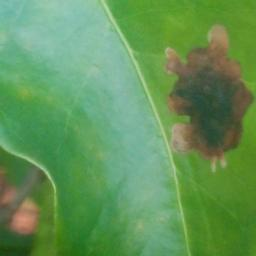

Leaf Rust Mask (Yellow/Orange Lesions):


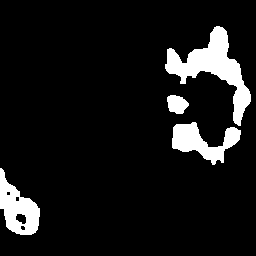

Phoma Mask (Dark Spots):


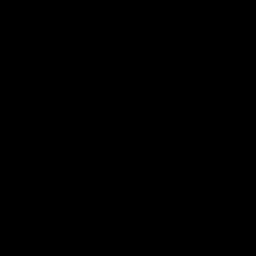

Segmented with Boundaries (Red: Rust, Blue: Phoma):


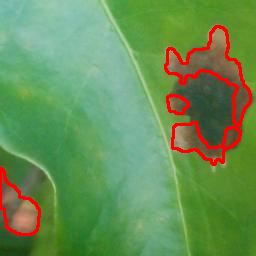

Overlay (Rust Mask):


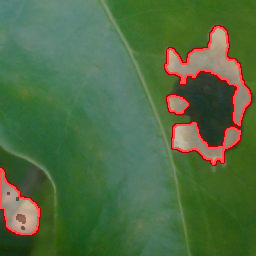

Overlay (Phoma Mask):


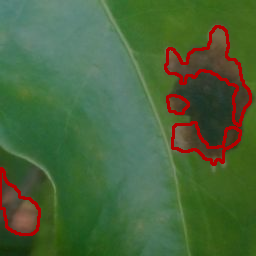

True

In [7]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Import Colab-specific display function

# Load the coffee leaf image
image_path = '/content/drive/MyDrive/coffeedataset2/phoma/23A38E~1.JPG'
img = cv2.imread(image_path)

if img is None:
    print("Error: Could not load the image. Check the path.")
    exit()

# Convert the image from BGR to HSV color space
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define HSV range for leaf rust (yellow/orange lesions)
lower_rust = np.array([10, 50, 50])  # Hue for yellow/orange
upper_rust = np.array([35, 255, 255])

# Define HSV range for phoma (dark spots, brown/gray/black)
lower_phoma = np.array([0, 0, 0])     # Broad Hue, low Value for dark areas
upper_phoma = np.array([179, 50, 50])

# Create binary masks for each disease
mask_rust = cv2.inRange(hsv, lower_rust, upper_rust)
mask_phoma = cv2.inRange(hsv, lower_phoma, upper_phoma)

# Apply morphological operations to clean up masks (reduce noise)
kernel = np.ones((3, 3), np.uint8)
mask_rust = cv2.morphologyEx(mask_rust, cv2.MORPH_OPEN, kernel)
mask_rust = cv2.morphologyEx(mask_rust, cv2.MORPH_CLOSE, kernel)
mask_phoma = cv2.morphologyEx(mask_phoma, cv2.MORPH_OPEN, kernel)
mask_phoma = cv2.morphologyEx(mask_phoma, cv2.MORPH_CLOSE, kernel)

# Find contours for each disease
contours_rust, _ = cv2.findContours(mask_rust, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_phoma, _ = cv2.findContours(mask_phoma, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the original image to draw on
output = img.copy()

# Initialize flags to check for disease presence
rust_detected = False
phoma_detected = False

# Draw red boundaries for leaf rust (yellow/orange lesions)
for contour in contours_rust:
    if cv2.contourArea(contour) > 100:  # Filter small contours
        cv2.drawContours(output, [contour], -1, (0, 0, 255), 2)  # Red color
        rust_detected = True

# Draw blue boundaries for phoma (dark spots)
for contour in contours_phoma:
    if cv2.contourArea(contour) > 100:  # Filter small contours
        cv2.drawContours(output, [contour], -1, (255, 0, 0), 2)  # Blue color
        phoma_detected = True

# Determine and print disease status
if rust_detected and phoma_detected:
    print("The leaf is affected by both leaf rust (yellow/orange lesions) and phoma (dark spots).")
elif rust_detected:
    print("The leaf is affected by leaf rust (yellow/orange lesions).")
elif phoma_detected:
    print("The leaf is affected by phoma (dark spots).")
else:
    print("No significant leaf rust or phoma detected.")

# Optional: Create overlays for visualization
output_with_mask_rust = cv2.addWeighted(output, 0.7, cv2.cvtColor(mask_rust, cv2.COLOR_GRAY2BGR), 0.3, 0)
output_with_mask_phoma = cv2.addWeighted(output, 0.7, cv2.cvtColor(mask_phoma, cv2.COLOR_GRAY2BGR), 0.3, 0)

# Display the results
print("Original Image:")
cv2_imshow(img)
print("Leaf Rust Mask (Yellow/Orange Lesions):")
cv2_imshow(mask_rust)
print("Phoma Mask (Dark Spots):")
cv2_imshow(mask_phoma)
print("Segmented with Boundaries (Red: Rust, Blue: Phoma):")
cv2_imshow(output)
print("Overlay (Rust Mask):")
cv2_imshow(output_with_mask_rust)
print("Overlay (Phoma Mask):")
cv2_imshow(output_with_mask_phoma)

# Save the output
cv2.imwrite('segmented_coffee_leaf.jpg', output)

Original Image:


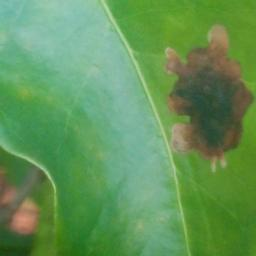

Leaf Rust Mask (Red):


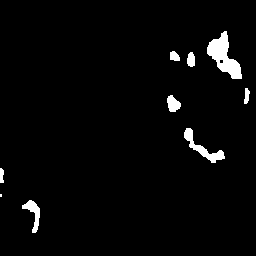

Phoma Mask (Blue, black spots):


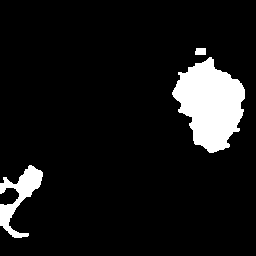

Overlay Highlighted Diseased Regions:


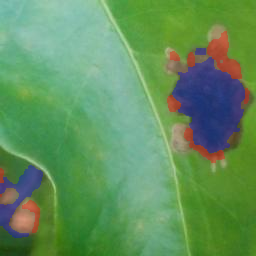

Boundaries Drawn and Labeled (Red: Leaf Rust, Blue: Phoma):


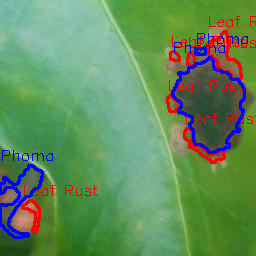

In [8]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the coffee leaf image
image_path = '/content/drive/MyDrive/coffeedataset2/phoma/23A38E~1.JPG'
img = cv2.imread(image_path)

if img is None:
    print("Error: Could not load the image. Check the path.")
    exit()

# Apply slight Gaussian blur to reduce noise
img_blur = cv2.GaussianBlur(img, (5, 5), 0)

# Convert to HSV
hsv = cv2.cvtColor(img_blur, cv2.COLOR_BGR2HSV)

# --------------------
# Leaf Rust (yellow/orange lesions)
# --------------------
lower_rust = np.array([15, 100, 100])
upper_rust = np.array([35, 255, 255])
mask_rust = cv2.inRange(hsv, lower_rust, upper_rust)

# --------------------
# Phoma (black spots)
# --------------------
# Focus only on black pixels: low Value (V) and low Saturation (S)
lower_phoma = np.array([0, 0, 0])
upper_phoma = np.array([179, 115, 115])  # Allow some tolerance for dark gray/black
mask_phoma = cv2.inRange(hsv, lower_phoma, upper_phoma)

# Remove overlap with Leaf Rust
mask_phoma = cv2.bitwise_and(mask_phoma, cv2.bitwise_not(mask_rust))

# Morphological cleaning to reduce noise
kernel = np.ones((3,3), np.uint8)
mask_rust = cv2.morphologyEx(mask_rust, cv2.MORPH_OPEN, kernel)
mask_rust = cv2.morphologyEx(mask_rust, cv2.MORPH_CLOSE, kernel)
mask_phoma = cv2.morphologyEx(mask_phoma, cv2.MORPH_OPEN, kernel)
mask_phoma = cv2.morphologyEx(mask_phoma, cv2.MORPH_CLOSE, kernel)

# --------------------
# Find contours and draw boundaries with labels
# --------------------
output = img.copy()
rust_detected = False
phoma_detected = False

# Leaf Rust (RED)
contours_rust, _ = cv2.findContours(mask_rust, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours_rust:
    if cv2.contourArea(cnt) > 50:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.drawContours(output, [cnt], -1, (0,0,255), 2)
        cv2.putText(output, "Leaf Rust", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)
        rust_detected = True

# Phoma (BLUE)
contours_phoma, _ = cv2.findContours(mask_phoma, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours_phoma:
    if cv2.contourArea(cnt) > 50:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.drawContours(output, [cnt], -1, (255,0,0), 2)
        cv2.putText(output, "Phoma", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
        phoma_detected = True

# --------------------
# Overlay visualization
# --------------------
overlay = img.copy()
overlay[np.where(mask_rust != 0)] = [0,0,255]
overlay[np.where(mask_phoma != 0)] = [255,0,0]
overlay_combined = cv2.addWeighted(img, 0.7, overlay, 0.3, 0)

# --------------------
# Display results
# --------------------
print("Original Image:")
cv2_imshow(img)
print("Leaf Rust Mask (Red):")
cv2_imshow(mask_rust)
print("Phoma Mask (Blue, black spots):")
cv2_imshow(mask_phoma)
print("Overlay Highlighted Diseased Regions:")
cv2_imshow(overlay_combined)
print("Boundaries Drawn and Labeled (Red: Leaf Rust, Blue: Phoma):")
cv2_imshow(output)

# Save results
#cv2.imwrite('/content/drive/MyDrive/segmented_leaf_boundaries_blackspots.jpg', output)
#cv2.imwrite('/content/drive/MyDrive/segmented_leaf_overlay_blackspots.jpg', overlay_combined)


In [10]:
!pip install opencv-python

 Classification model: EfficientNetB0 (transfer learning) — chosen for a good accuracy / compute tradeoff
- Segmentation: heuristic HSV-based lesion segmentation (no pixel-level masks required).
Outputs:
- Saved classification model at: /content/drive/MyDrive/coffee_leaf_effnetb0_leafrust_phoma.h5
- Example overlay images saved to /content/drive/MyDrive/segmentation_results/

Found 1714 images belonging to 2 classes.
Found 428 images belonging to 2 classes.
Class indices: {'leaf rust': 0, 'phoma': 1}
Train counts: Counter({np.int32(1): 888, np.int32(0): 826})
Val counts: Counter({np.int32(1): 222, np.int32(0): 206})


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6617 - loss: 0.5944
Epoch 1: val_accuracy improved from -inf to 0.64953, saving model to /content/drive/MyDrive/coffee_leaf_effnetb0_leafrust_phoma.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 232s 4s/step - accuracy: 0.6632 - loss: 0.5927 - val_accuracy: 0.6495 - val_loss: 0.5807
Epoch 2/8
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8554 - loss: 0.3545
Epoch 2: val_accuracy improved from 0.64953 to 0.74766, saving model to /content/drive/MyDrive/coffee_leaf_effnetb0_leafrust_phoma.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 209s 4s/step - accuracy: 0.8555 - loss: 0.3542 - val_accuracy: 0.7477 - val_loss: 0.4683
Epoch 3/8
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8915 - loss: 0.2970
Epoch 3: val_accuracy improved from 0.74766 to 0.76402, saving model to /content/drive/MyDrive/coffee_leaf_effnetb0_leafrust_phoma.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 206s 4s/step - accuracy: 0.8916 - loss: 0.2968 - val_accuracy: 0.7640 - val_loss: 0.4450
Epoch 4/8
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8956 - loss: 0.2600
Epoch 4: val_accuracy improved from 0.76402 to 0.78972, saving model to /content/drive/MyDrive/coffee_leaf_effnetb0_leafrust_phoma.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - accuracy: 0.8957 - loss: 0.2598 - val_accuracy: 0.7897 - val_loss: 0.4122
Epoch 5/8
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9187 - loss: 0.2160
Epoch 5: val_accuracy did not improve from 0.78972
54/54 ━━━━━━━━━━━━━━━━━━━━ 198s 4s/step - accuracy: 0.9186 - loss: 0.2161 - val_accuracy: 0.7547 - val_loss: 0.4291
Epoch 6/8
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9209 - loss: 0.2131
Epoch 6: val_accuracy improved from 0.78972 to 0.82944, saving model to /content/drive/MyDrive/coffee_leaf_effnetb0_leafrust_phoma.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - accuracy: 0.9208 - loss: 0.2130 - val_accuracy: 0.8294 - val_loss: 0.3560
Epoch 7/8
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9294 - loss: 0.2021
Epoch 7: val_accuracy improved from 0.82944 to 0.83178, saving model to /content/drive/MyDrive/coffee_leaf_effnetb0_leafrust_phoma.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - accuracy: 0.9294 - loss: 0.2019 - val_accuracy: 0.8318 - val_loss: 0.3553
Epoch 8/8
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9273 - loss: 0.1888
Epoch 8: val_accuracy did not improve from 0.83178
54/54 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - accuracy: 0.9274 - loss: 0.1887 - val_accuracy: 0.8107 - val_loss: 0.3625
Restoring model weights from the end of the best epoch: 7.
Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8449 - loss: 0.3502
Epoch 1: val_accuracy did not improve from 0.83178
54/54 ━━━━━━━━━━━━━━━━━━━━ 325s 5s/step - accuracy: 0.8450 - loss: 0.3500 - val_accuracy: 0.8131 - val_loss: 0.3979
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8828 - loss: 0.3021
Epoch 2: val_accuracy improved from 0.83178 to 0.83411, saving model to /content/drive/MyDrive/coffee_leaf_effnetb0_leafrust_phoma.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 292s 5s/step - accuracy: 0.8831 - loss: 0.3017 - val_accuracy: 0.8341 - val_loss: 0.4280
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9031 - loss: 0.2470
Epoch 3: val_accuracy did not improve from 0.83411
54/54 ━━━━━━━━━━━━━━━━━━━━ 294s 5s/step - accuracy: 0.9030 - loss: 0.2471 - val_accuracy: 0.8341 - val_loss: 0.4211
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9066 - loss: 0.2256
Epoch 4: val_accuracy did not improve from 0.83411
54/54 ━━━━━━━━━━━━━━━━━━━━ 282s 5s/step - accuracy: 0.9068 - loss: 0.2255 - val_accuracy: 0.8248 - val_loss: 0.3893
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9243 - loss: 0.1915
Epoch 5: val_accuracy did not improve from 0.83411
54/54 ━━━━━━━━━━━━━━━━━━━━ 284s 5s/step - accuracy: 0.9246 - loss: 0.1913 - val_accuracy: 0.8341 - val_loss: 0.3616
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9403 - loss: 0.1708
Epoch 6: val_accuracy improved from 0.83411 to 0.85

54/54 ━━━━━━━━━━━━━━━━━━━━ 285s 5s/step - accuracy: 0.9404 - loss: 0.1707 - val_accuracy: 0.8528 - val_loss: 0.3373
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9357 - loss: 0.1799
Epoch 7: val_accuracy improved from 0.85280 to 0.85748, saving model to /content/drive/MyDrive/coffee_leaf_effnetb0_leafrust_phoma.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 325s 5s/step - accuracy: 0.9358 - loss: 0.1797 - val_accuracy: 0.8575 - val_loss: 0.3143
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9475 - loss: 0.1468
Epoch 8: val_accuracy did not improve from 0.85748
54/54 ━━━━━━━━━━━━━━━━━━━━ 296s 6s/step - accuracy: 0.9476 - loss: 0.1467 - val_accuracy: 0.8528 - val_loss: 0.3096
Epoch 9/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9681 - loss: 0.1263
Epoch 9: val_accuracy improved from 0.85748 to 0.85981, saving model to /content/drive/MyDrive/coffee_leaf_effnetb0_leafrust_phoma.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 291s 5s/step - accuracy: 0.9680 - loss: 0.1263 - val_accuracy: 0.8598 - val_loss: 0.2917
Epoch 10/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9556 - loss: 0.1226
Epoch 10: val_accuracy did not improve from 0.85981
54/54 ━━━━━━━━━━━━━━━━━━━━ 286s 5s/step - accuracy: 0.9556 - loss: 0.1227 - val_accuracy: 0.8575 - val_loss: 0.2770
Epoch 11/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9672 - loss: 0.1106
Epoch 11: val_accuracy improved from 0.85981 to 0.87617, saving model to /content/drive/MyDrive/coffee_leaf_effnetb0_leafrust_phoma.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 284s 5s/step - accuracy: 0.9672 - loss: 0.1106 - val_accuracy: 0.8762 - val_loss: 0.2639
Epoch 12/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9743 - loss: 0.0955
Epoch 12: val_accuracy improved from 0.87617 to 0.88551, saving model to /content/drive/MyDrive/coffee_leaf_effnetb0_leafrust_phoma.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 286s 5s/step - accuracy: 0.9743 - loss: 0.0956 - val_accuracy: 0.8855 - val_loss: 0.2571
Epoch 13/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9595 - loss: 0.1166
Epoch 13: val_accuracy improved from 0.88551 to 0.88785, saving model to /content/drive/MyDrive/coffee_leaf_effnetb0_leafrust_phoma.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 338s 6s/step - accuracy: 0.9596 - loss: 0.1164 - val_accuracy: 0.8879 - val_loss: 0.2501
Epoch 14/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9632 - loss: 0.1043
Epoch 14: val_accuracy did not improve from 0.88785
54/54 ━━━━━━━━━━━━━━━━━━━━ 288s 5s/step - accuracy: 0.9632 - loss: 0.1043 - val_accuracy: 0.8879 - val_loss: 0.2535
Epoch 15/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9675 - loss: 0.0973
Epoch 15: val_accuracy did not improve from 0.88785
54/54 ━━━━━━━━━━━━━━━━━━━━ 286s 5s/step - accuracy: 0.9675 - loss: 0.0973 - val_accuracy: 0.8879 - val_loss: 0.2408
Restoring model weights from the end of the best epoch: 13.



✅ Classification model saved to: /content/drive/MyDrive/coffee_leaf_effnetb0_leafrust_phoma.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8638 - loss: 0.2652
evaluate() -> val_loss: 0.2501, val_accuracy: 88.79%
history last reported val_accuracy: 88.79%
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Confusion matrix:
[[180  26]
 [ 22 200]]

Classification report:
              precision    recall  f1-score   support

   leaf rust       0.89      0.87      0.88       206
       phoma       0.88      0.90      0.89       222

 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


428/428 ━━━━━━━━━━━━━━━━━━━━ 51s 113ms/step

===== Classification Report =====
              precision    recall  f1-score   support

   leaf rust       0.89      0.87      0.88       206
       phoma       0.88      0.90      0.89       222

    accuracy                           0.89       428
   macro avg       0.89      0.89      0.89       428
weighted avg       0.89      0.89      0.89       428



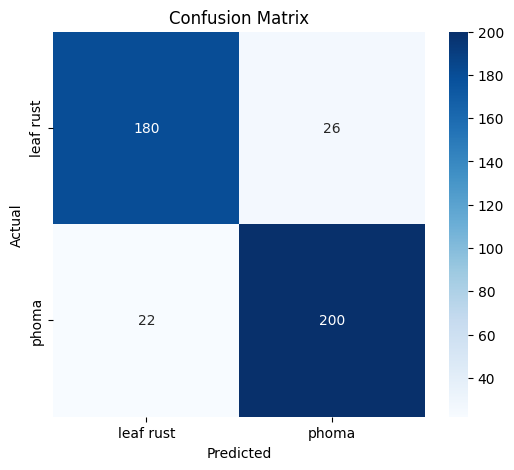

ROC-AUC Score: 0.9644
MCC: 0.7754


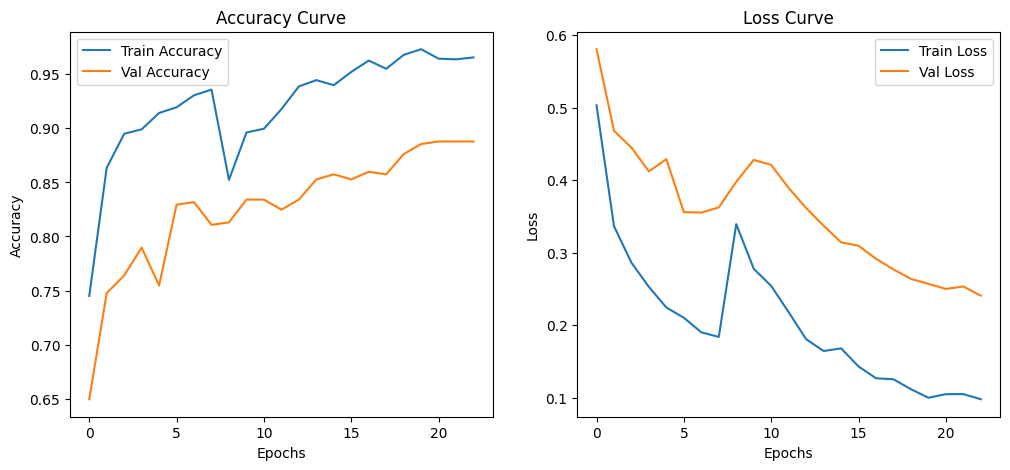

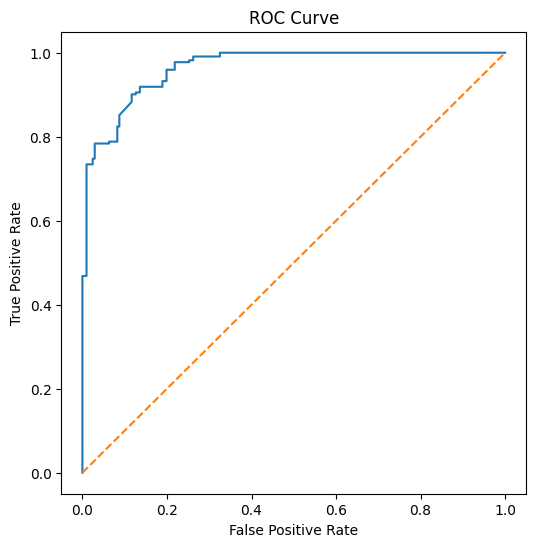

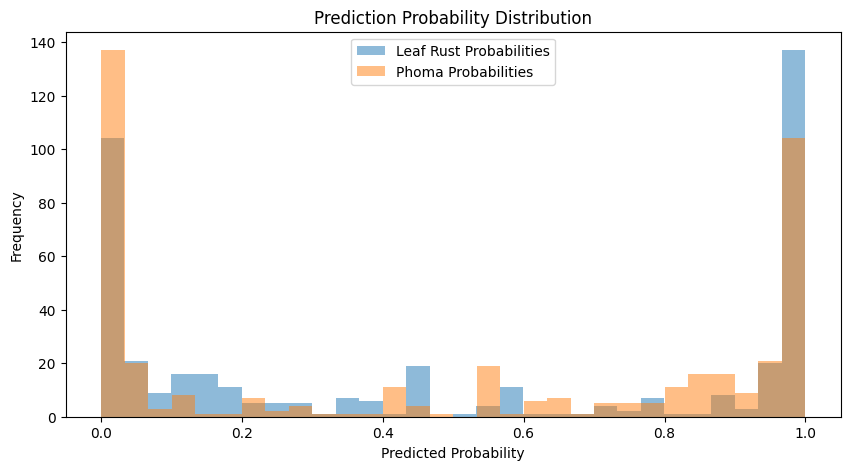

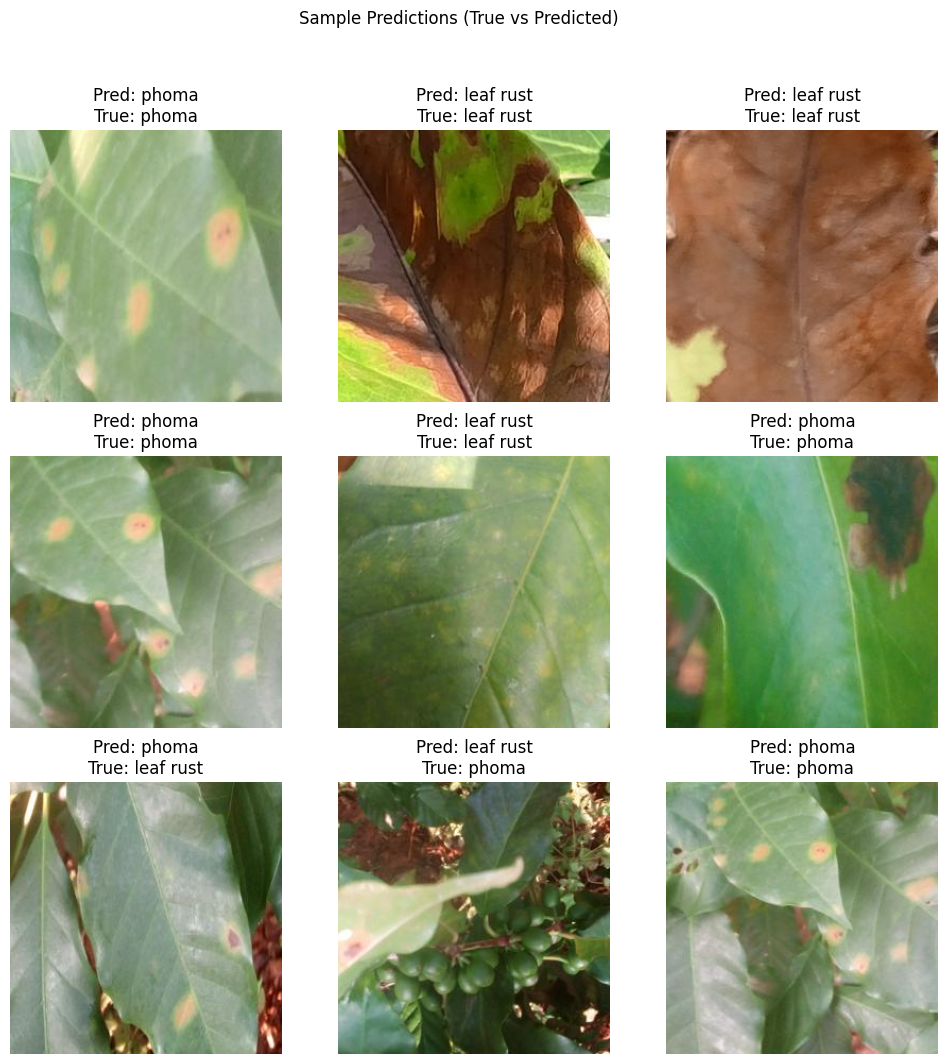

In [16]:

import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
import collections

# -----------------------------
# User parameters
# -----------------------------
dataset_dir = "/content/drive/MyDrive/coffeedataset2"  # contains leaf_rust, phoma, healthy
img_size = 224
batch_size = 32
epochs_head = 8
epochs_finetune = 15
classes_to_use = ['leaf rust', 'phoma']

# -----------------------------
# 1) Data generators (classification) - using preprocess_input FOR BOTH train and val
# -----------------------------
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2)
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    classes=classes_to_use,
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    classes=classes_to_use,
    shuffle=False  # important for reliable evaluation and mapping
)

print("Class indices:", train_gen.class_indices)
print("Train counts:", collections.Counter(train_gen.classes))
print("Val counts:", collections.Counter(val_gen.classes))

# -----------------------------
# 2) Build classification model (EfficientNetB0)
# -----------------------------
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # freeze base for initial training

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(len(classes_to_use), activation='softmax')(x)

clf_model = Model(inputs=base_model.input, outputs=outputs)
clf_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
ckpt_path = '/content/drive/MyDrive/coffee_leaf_effnetb0_leafrust_phoma.h5'
callbacks = [
    ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1)
]

# -----------------------------
# 3) Train head
# -----------------------------
history_head = clf_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs_head,
    callbacks=callbacks
)

# -----------------------------
# 4) Fine-tune: unfreeze top layers and continue with a low LR
# -----------------------------
base_model.trainable = True
# freeze all except last N layers
N = 100
for layer in base_model.layers[:-N]:
    layer.trainable = False
for layer in base_model.layers[-N:]:
    layer.trainable = True

clf_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history_finetune = clf_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs_finetune,
    callbacks=callbacks
)

# Save final model
clf_model.save(ckpt_path)
print(f'\n✅ Classification model saved to: {ckpt_path}')

# -----------------------------
# 5) Correct & reliable evaluation (this is the key change)
# - ensure we evaluate using the SAME val_gen and correct number of steps
# - print both evaluate() outputs and history-reported final val_accuracy for cross-check
# -----------------------------
val_gen.reset()
steps = len(val_gen)
val_loss, val_acc = clf_model.evaluate(val_gen, steps=steps, verbose=1)
print(f"evaluate() -> val_loss: {val_loss:.4f}, val_accuracy: {val_acc*100:.2f}%")

# final val_accuracy from training history
last_val_acc = None
if history_finetune and 'val_accuracy' in history_finetune.history:
    last_val_acc = history_finetune.history['val_accuracy'][-1]
elif history_head and 'val_accuracy' in history_head.history:
    last_val_acc = history_head.history['val_accuracy'][-1]

if last_val_acc is not None:
    print(f"history last reported val_accuracy: {last_val_acc*100:.2f}%")

# -----------------------------
# 6) Confusion matrix + misclassified samples dump
# -----------------------------
# Collect all predictions on validation set (in the same order because shuffle=False)
val_gen.reset()
y_true = []
y_pred = []
filenames = []
for i in range(len(val_gen)):
    x_batch, y_batch = val_gen[i]
    preds = clf_model.predict(x_batch)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    # compute corresponding filenames for this batch
    batch_start = i * val_gen.batch_size
    batch_end = batch_start + x_batch.shape[0]
    filenames.extend(val_gen.filenames[batch_start:batch_end])

cm = confusion_matrix(y_true, y_pred)
print(f'\nConfusion matrix:\n{cm}')
print(f'\nClassification report:\n{classification_report(y_true, y_pred, target_names=list(train_gen.class_indices.keys()))}')

# Save misclassified images for inspection
mis_dir = '/content/drive/MyDrive/misclassified_examples'
os.makedirs(mis_dir, exist_ok=True)
count = 0
for true_idx, pred_idx, fname in zip(y_true, y_pred, filenames):
    if true_idx != pred_idx and count < 50:
        # load original image and save with annotation
        path = os.path.join(dataset_dir, fname)
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        display = cv2.resize(img, (img_size, img_size))
        text = f"true:{list(train_gen.class_indices.keys())[true_idx]} pred:{list(train_gen.class_indices.keys())[pred_idx]}"
        cv2.putText(display, text, (8, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
        outpath = os.path.join(mis_dir, f"mis_{count}_" + os.path.basename(fname))
        plt.imsave(outpath, display)
        count += 1

print(f"Saved {count} misclassified examples to: {mis_dir}")

# -----------------------------
# 7) Segmentation: HSV heuristic pipeline (unchanged from before) - saves overlays for a small set
# -----------------------------

def segment_lesions_hsv(rgb_image):
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    lower_rust = np.array([5, 80, 80])
    upper_rust = np.array([30, 255, 255])
    mask_rust = cv2.inRange(hsv, lower_rust, upper_rust)
    lower_phoma1 = np.array([0, 30, 0])
    upper_phoma1 = np.array([179, 255, 90])
    mask_phoma = cv2.inRange(hsv, lower_phoma1, upper_phoma1)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    mask_rust = cv2.morphologyEx(mask_rust, cv2.MORPH_OPEN, kernel, iterations=1)
    mask_rust = cv2.morphologyEx(mask_rust, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask_phoma = cv2.morphologyEx(mask_phoma, cv2.MORPH_OPEN, kernel, iterations=1)
    mask_phoma = cv2.morphologyEx(mask_phoma, cv2.MORPH_CLOSE, kernel, iterations=2)
    return mask_rust, mask_phoma


def overlay_masks(rgb_image, mask_rust, mask_phoma, alpha=0.6):
    overlay = rgb_image.copy()
    overlay[mask_rust > 0] = (255, 120, 0)
    overlay[mask_phoma > 0] = (60, 60, 160)
    blended = cv2.addWeighted(overlay, alpha, rgb_image, 1 - alpha, 0)
    out = blended.copy()
    contours_rust, _ = cv2.findContours(mask_rust, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_phoma, _ = cv2.findContours(mask_phoma, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(out, contours_rust, -1, (255, 0, 0), 2)
    cv2.drawContours(out, contours_phoma, -1, (0, 0, 255), 2)
    def label_largest(contours, label, color=(255,255,255)):
        if not contours:
            return
        largest = max(contours, key=cv2.contourArea)
        M = cv2.moments(largest)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            cv2.putText(out, label, (cx-30, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2, cv2.LINE_AA)
    label_largest(contours_rust, 'leaf rust', color=(255,255,255))
    label_largest(contours_phoma, 'phoma', color=(255,255,255))
    return out

# Save segmentation overlays for first 12 validation images
save_dir = '/content/drive/MyDrive/segmentation_results'
os.makedirs(save_dir, exist_ok=True)
from tensorflow.keras.preprocessing import image as kimage

sample_paths = []
for fname in val_gen.filenames[:12]:
    sample_paths.append(os.path.join(dataset_dir, fname))

for i, path in enumerate(sample_paths):
    img = kimage.load_img(path, target_size=(img_size, img_size))
    x = kimage.img_to_array(img) / 255.0
    x_batch = np.expand_dims(x, axis=0)
    preds = clf_model.predict(x_batch)
    pred_idx = np.argmax(preds[0])
    pred_label = classes_to_use[pred_idx]
    pred_conf = preds[0][pred_idx]
    orig = cv2.imread(path)
    if orig is None:
        continue
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    display = cv2.resize(orig, (img_size, img_size))
    mask_rust, mask_phoma = segment_lesions_hsv(display)
    overlay = overlay_masks(display, mask_rust, mask_phoma, alpha=0.6)
    label_text = f"Pred: {pred_label} ({pred_conf*100:.1f}%)"
    cv2.putText(overlay, label_text, (8, 22), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2, cv2.LINE_AA)
    out_path = os.path.join(save_dir, f"result_{i}_" + os.path.basename(path))
    plt.imsave(out_path, overlay)

print(f'\n✅ Segmentation results saved to: {save_dir}')

# =============================
# 7. Evaluation Metrics
# =============================
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate model on validation set
eval_loss, eval_acc = clf_model.evaluate(val_gen, steps=len(val_gen))
print(f"Validation Loss: {eval_loss:.4f}")
print(f"Validation Accuracy: {eval_acc:.4f}")

# Predictions for detailed metrics
val_gen_noshuffle = val_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_size, img_size),
    batch_size=1,
    class_mode='categorical',
    subset='validation',
    classes=classes_to_use,
    shuffle=False
)

y_true = val_gen_noshuffle.classes
y_pred_probs = clf_model.predict(val_gen_noshuffle, steps=len(val_gen_noshuffle))
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print(f"\n===== Classification Report =====")
print(classification_report(y_true, y_pred, target_names=classes_to_use))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes_to_use, yticklabels=classes_to_use)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC
auc_score = roc_auc_score(y_true, y_pred_probs[:,1])
print(f"ROC-AUC Score: {auc_score:.4f}")

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_true, y_pred)
print(f"MCC: {mcc:.4f}")


# =============================
# 8. Additional Visualizations
# =============================

# Combine histories for plotting
combined_history = {}
for key in history_head.history.keys():
    combined_history[key] = history_head.history[key] + history_finetune.history[key]

# ----- 1. Training Curves (Accuracy & Loss) -----
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(combined_history['accuracy'], label='Train Accuracy')
plt.plot(combined_history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(combined_history['loss'], label='Train Loss')
plt.plot(combined_history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ----- 2. ROC Curve -----
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs[:,1])
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# ----- 3. Probability Distribution for Each Class -----
plt.figure(figsize=(10,5))
plt.hist(y_pred_probs[:,0], bins=30, alpha=0.5, label='Leaf Rust Probabilities')
plt.hist(y_pred_probs[:,1], bins=30, alpha=0.5, label='Phoma Probabilities')
plt.title('Prediction Probability Distribution')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# ----- 4. Display 9 Example Predictions -----
import random
indices = random.sample(range(len(y_true)), 9)
plt.figure(figsize=(12,12))
for i, idx in enumerate(indices):
    img_path = val_gen_noshuffle.filepaths[idx]
    img = plt.imread(img_path)
    pred_class = classes_to_use[y_pred[idx]]
    true_class = classes_to_use[y_true[idx]]

    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(f"Pred: {pred_class}\nTrue: {true_class}")
    plt.axis('off')
plt.suptitle('Sample Predictions (True vs Predicted)')
plt.show()
